In [2]:
## INSTALL THESE LIBRARES
# ! pip install tensorflow

In [4]:
import os
import sys
from IPython.display import Markdown, display
import re
from string import punctuation
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

    
def handle_helper_functions():
    print(sys.path)
    directory_path = os.path.abspath(os.path.join('../../helper'))
    if directory_path not in sys.path:
        sys.path.append(directory_path)    

    translation_path=os.path.abspath(os.path.join('../../utils')) 
    if translation_path not in sys.path:
        sys.path.append(translation_path)   
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/machine-learning/test/helper')                                       
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/machine-learning/utils')
    sys.path.append('/Users/learn/Desktop/Projects/machine-translation/machine-learning/data')


    lstm_helper_path = os.path.abspath(os.path.join('./create-model/lstm/'))
    if lstm_helper_path not in sys.path:
        sys.path.append(lstm_helper_path)    

    print(sys.path)
    

handle_helper_functions()

['/Users/learn/Desktop/Projects/machine-translation/machine-learning/train/lstm', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages']
['/Users/learn/Desktop/Projects/machine-translation/machine-learning/train/lstm', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python39.zip', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/lib-dynload', '', '/Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages', '/Users/learn/Desktop/Projects/machine-translation/machine

In [5]:
from iit_dataset import createDataset


Using custom data configuration cfilt--iitb-english-hindi-911387c6837f8b91
Reusing dataset parquet (/Users/learn/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-911387c6837f8b91/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
class Translator():
    def __init__(self, training_size=10000) -> None:
        self.training_size=training_size
        self.idx_src=0
        self.idx_tar = 1
        self.source_str, self.target_str = "Hindi", "English"
        self.tar_tokenizer=None
        self.tar_vocab_size=None
        self.src_tokenizer=None
        self.tar_length=None
        self.src_vocab_size=None
        self.src_length=None
        self.trainX=None
        self.trainY=None
        self._convert_sentence_to_vectors()
        pass
    def train_model(self):
        ''' 
        GET TRAINING DATA FROM IIT DATASET
        TURN THEM INTO VECTORS
        CREATE ENCODER DICTIONARY 
        SAVE THEM INSIDE THE CLASS
        '''
        pass
    def _get_training_data(self):
        pool_oftexts, pairs =createDataset(data_size=self.training_size, type="train")
        dataset= pool_oftexts
        return dataset
    
    def clean(self,string):
        string = string.replace("\u202f"," ")
        string = string.lower()
        for p in punctuation + "«»" + "0123456789":
            string = string.replace(p," ")  
        string = re.sub('\s+',' ', string)
        string = string.strip()
            
        return string
    
    def _generate_train_test_split(self):
        ''' 
        GET TRAINING DATA AND SPLIT THEM TO TRAIN AND TEST SET

        RETURN dataset, train, test
        '''
        dataset= self._get_training_data()
        total_sentences= len(dataset)
        test_proportion = 0.1
        train_test_threshold = int( (1-test_proportion) * total_sentences)

        dataset["eng"] = dataset["eng"].apply(lambda x: self.clean(x))
        dataset["hindi"] = dataset["hindi"].apply(lambda x: self.clean(x))

        dataset = dataset.values
        dataset = dataset[:total_sentences]

        train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

        return dataset, train, test
    def create_tokenizer(self,lines):
        # fit a tokenizer
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(lines)
        return tokenizer
 

    def encode_sequences(self,tokenizer, length, lines):
        # encode and pad sequences
        X = tokenizer.texts_to_sequences(lines) # integer encode sequences
        X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
        return X
    
    def encode_output(self,sequences, vocab_size):
        # one hot encode target sequence
        ylist = list()
        for sequence in sequences:
            encoded = to_categorical(sequence, num_classes=vocab_size)
            ylist.append(encoded)
        y = np.array(ylist)
        y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
        return y
 

    def _convert_sentence_to_vectors(self):
        ''' 
        GENERATE TRAIN TEST SPLIT
        CREATE TARGET TOKENIZER
        CREATE SOURCE TOKENIZER
        RETURN VECTORS FOR TRAINING
        '''
        dataset, train, test= self. _generate_train_test_split()
        # Prepare target tokenizer
        tar_tokenizer = self.create_tokenizer(dataset[:, self.idx_tar]) #save
        tar_vocab_size = len(tar_tokenizer.word_index) + 1  #save
        tar_length = 15  #save
        printmd(f'\nTarget ({self.target_str}) Vocabulary Size: {tar_vocab_size}')
        printmd(f'Target ({self.target_str}) Max Length: {tar_length}')

        # Prepare source tokenizer
        src_tokenizer = self.create_tokenizer(dataset[:, self.idx_src])  #save
        src_vocab_size = len(src_tokenizer.word_index) + 1  #save
        src_length = 15  #save
        #### SAVE
        self.tar_tokenizer=tar_tokenizer
        self.tar_vocab_size=tar_vocab_size
        self.src_tokenizer=src_tokenizer
        self.tar_length=tar_length
        self.src_vocab_size=src_vocab_size
        self.src_length=src_length
        ### SAVE
        printmd(f'\nSource ({self.source_str}) Vocabulary Size: {src_vocab_size}')
        printmd(f'Source ({self.source_str}) Max Length: {src_length}\n')
        # PREPARING TRAINING DATA
        trainX = self.encode_sequences(src_tokenizer, src_length, train[:, self.idx_src])
        trainY = self.encode_sequences(tar_tokenizer, tar_length, train[:, self.idx_tar])
        trainY = self.encode_output(trainY, tar_vocab_size)
        self.trainX=trainX
        self.trainY=trainY
        pass
    
    def create_model(self, src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
        # Create the model
        model = Sequential()
        model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
        model.add(LSTM(n_units))
        model.add(RepeatVector(tar_timesteps))
        model.add(LSTM(n_units, return_sequences=True))
        model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
        return model
    
    def train(self):
        # Create model
        model = self.create_model(self.src_vocab_size, self.tar_vocab_size, self.src_length, self.tar_length, 256)
        model.compile(optimizer='adam', loss='categorical_crossentropy')
        #######################
        # display("TRAIN X: ",self.trainX)
        # display("TRAIN Y ",self.trainY)
        # display(model)
        #######################
        history = model.fit(self.trainX, 
               self.trainY, 
                epochs=10,#200 
                batch_size=64, 
                validation_split=0.1, 
                verbose=1,
                callbacks=[
                                EarlyStopping(
                                monitor='val_loss',
                                patience=10,
                                restore_best_weights=True
                            )
                    ])


        model.summary()
        # save model in computer '/Users/learn/Desktop/Projects/machine-translation/machine-learning/data'
        # model.save()
        pd.DataFrame(history.history).plot()
        plt.title("Loss")
        plt.show()



In [7]:
translator= Translator(training_size=25000)


Target (English) Vocabulary Size: 1998

Target (English) Max Length: 15


Source (Hindi) Vocabulary Size: 2494

Source (Hindi) Max Length: 15


2023-08-03 15:56:36.116431: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-03 15:56:36.116491: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-03 15:56:36.116514: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-03 15:56:36.116716: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-03 15:56:36.116743: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2023-08-03 15:56:40.626188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:56:41.062218: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_40/output/_23'
2023-08-03 15:56:41.066683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:5

317/317 [==============================] - ETA: 0s - loss: 1.9127

2023-08-03 15:57:01.421759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:57:01.653937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-03 15:57:01.813955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


317/317 [==============================] - 24s 66ms/step - loss: 1.9127 - val_loss: 1.9498
Epoch 2/10
317/317 [==============================] - 17s 55ms/step - loss: 1.7010 - val_loss: 1.9167
Epoch 3/10
317/317 [==============================] - 19s 60ms/step - loss: 1.6781 - val_loss: 1.9183
Epoch 4/10
317/317 [==============================] - 19s 60ms/step - loss: 1.6569 - val_loss: 1.8891
Epoch 5/10
317/317 [==============================] - 20s 62ms/step - loss: 1.5899 - val_loss: 1.7976
Epoch 6/10
317/317 [==============================] - 19s 60ms/step - loss: 1.4242 - val_loss: 1.6099
Epoch 7/10
317/317 [==============================] - 19s 61ms/step - loss: 1.3557 - val_loss: 1.5364
Epoch 8/10
317/317 [==============================] - 20s 62ms/step - loss: 1.3015 - val_loss: 1.4875
Epoch 9/10
317/317 [==============================] - 21s 65ms/step - loss: 1.2214 - val_loss: 1.4043
Epoch 10/10
317/317 [==============================] - 20s 64ms/step - loss: 1.1518 - val_los

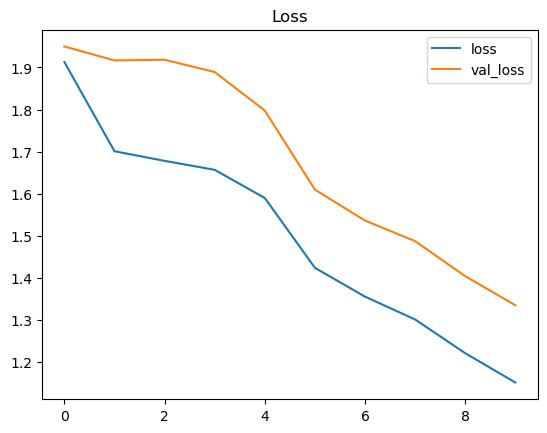

In [8]:
translator.train()

In [9]:
!jupyter kernelspec list


Available kernels:
  python3                /Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages/ipykernel/resources
  machine-learning       /Users/learn/Library/Jupyter/kernels/machine-learning
  machine-translation    /Users/learn/Library/Jupyter/kernels/machine-translation
  scalis                 /Users/learn/Library/Jupyter/kernels/scalis
  threebie_ads           /Users/learn/Library/Jupyter/kernels/threebie_ads


In [10]:
! jupyter kernelspec uninstall silicon-kernel  -f 
! jupyter kernelspec list



Couldn't find kernel spec(s): silicon-kernel
Available kernels:
  python3                /Users/learn/Desktop/Projects/machine-translation/machine-learning/venv/lib/python3.9/site-packages/ipykernel/resources
  machine-learning       /Users/learn/Library/Jupyter/kernels/machine-learning
  machine-translation    /Users/learn/Library/Jupyter/kernels/machine-translation
  scalis                 /Users/learn/Library/Jupyter/kernels/scalis
  threebie_ads           /Users/learn/Library/Jupyter/kernels/threebie_ads
